In [122]:
import numpy as np
import pandas as pd
import pm4py
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.statistics.eventually_follows.log import get as efg_get
from pm4py.algo.filtering.dfg import dfg_filtering
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import *
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import variation
from scipy import stats
import sklearn.preprocessing as sk
from scipy.stats import chi2_contingency
import math
import statistics
import graphviz
from statsmodels.stats import multitest
from statsmodels.stats.contingency_tables import SquareTable as ST
import sys
import sklearn
import scipy
from scipy.stats import shapiro
import os
import json
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
pd.set_option("display.max_columns", 500)

In [124]:
#MIMIC-IV
com_pm = pd.read_csv("Outputs/Kidney_Transformed_Var.csv")
el = pd.read_csv("Outputs/Kidney_Transformed_Var.csv")
con_All = pd.read_csv("Outputs/Change_Detection_Kidney_con_All.csv")
cat_All = pd.read_csv("Outputs/Change_Detection_Kidney_cat_All.csv")
df_cat = pd.read_csv("Outputs/Change_Detection_Kidney_df_cat.csv")
df_con = pd.read_csv("Outputs/Change_Detection_Kidney_df_con.csv")

In [125]:
df_con = df_con.loc[df_con["Directly"] == 1.0]

In [126]:
con_All = con_All.loc[con_All["Directly"] == 1.0]

In [127]:
#Create columns for relations and switch sign of Rel to show correct direction of values
df_con["Rel"] = df_con["Act_1"] + ":" + df_con["Act_2"]

con_All["Rel"] = con_All["Act_1"] + ":" + con_All["Act_2"]

df_cat["Rel"] = df_cat["Act_1"] + ":" + df_cat["Act_2"]

cat_All["Rel"] = cat_All["Act_1"] + ":" + cat_All["Act_2"]

con_All["RBC"] = -con_All["RBC"]

df_con["RBC"] = -df_con["RBC"]

In [128]:
#compute correlations

In [129]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from package.process_change_analyzer import ProcessChangeAnalyzer

In [130]:
# manually set inputs for the package
attribute_list_con = con_All["E_At"].unique().tolist()
attribute_list_cat = cat_All["E_At"].unique().tolist()
#specify activity and case id column
activity = "concept:name"
case_id = "case:hadm_id"
time_column = "time:timestamp"
#attribute_list_con = attribute_list_con[3:]
attribute_list_con.append("time:timestamp")
# type of variables to use
continuous_columns = attribute_list_con.copy()

categorical_columns = attribute_list_cat.copy()

In [131]:
analyzer = ProcessChangeAnalyzer(com_pm[com_pm.columns[:-1]], activity, case_id, time_column, continuous_columns, categorical_columns)

In [134]:
analyzer.prepare_correlation()

In [135]:
analyzer.distribution_checker().sort_values('stat')

,previous_activity,activity,measure,stat,p,is_normal_distributed
754,Post-ICU Medicine,Post-ICU Surgery,Glucose,0.821186,0.145963,True
347,Pre-ICU Cardiology,Medical ICU,sum_timestamp,0.838455,0.015539,False
869,Pre-ICU Medicine,Pre-ICU Cardiology,sum_timestamp,0.864751,0.011769,False
763,Post-ICU Medicine,Post-ICU Surgery,Phosphate,0.879243,0.335411,True
756,Post-ICU Medicine,Post-ICU Surgery,Sodium,0.891750,0.391247,True
...,...,...,...,...,...,...
1038,Pre-ICU Surgery,Surgical ICU,PT,NaN,1.000000,True
1039,Pre-ICU Surgery,Surgical ICU,pO2,NaN,1.000000,True
1040,Pre-ICU Surgery,Surgical ICU,Calculated Total CO2,NaN,1.000000,True
1041,Pre-ICU Surgery,Surgical ICU,pCO2,NaN,1.000000,True


In [136]:
analyzer.compute_correlations()

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [140]:
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:hadm_id'}
event_log = pm4py.format_dataframe(el, case_id='case:hadm_id', activity_key='concept:name', timestamp_key='time:timestamp')
log = pm4py.convert_to_event_log(event_log)

In [141]:
dfg = dfg_discovery.apply(log)
dfg, sa, ea = pm4py.discover_directly_follows_graph(log)
activities_count = pm4py.get_event_attribute_values(log, "concept:name")

In [142]:
#remove small sample size relations (optional)
l = list()
for x in dfg:
    if (dfg[x] <= 30):
        l.append(x)
for e in l:
    del(dfg[e])       

In [143]:
df_con = con_All.loc[con_All["P"] <= 0.05]

In [144]:
rel_list = list(df_con.groupby(["Rel"]).count().sort_values("E_At", ascending=False).reset_index()["Rel"])
att_list = list(df_con.groupby(["E_At"]).count().sort_values("Rel", ascending=False).reset_index()["E_At"])
var_list = list(df_con.groupby(["var"]).count().sort_values("Rel", ascending=False).reset_index()["var"])
rel_list.insert(0, "Select All")
att_list.insert(0, "Select All")
var_list.insert(0, "Select All")

In [145]:
dfg = dfg_discovery.apply(log)
dfg, sa, ea = pm4py.discover_directly_follows_graph(log)
activities_count = pm4py.get_event_attribute_values(log, "concept:name")
dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(dfg, sa, ea, activities_count, 1)
dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_paths_percentage(dfg, sa, ea, activities_count, 0.6)

In [146]:
gviz = dfg_visualization.apply(dfg, att_config={}, log=log, variant=dfg_visualization.Variants.FREQUENCY)

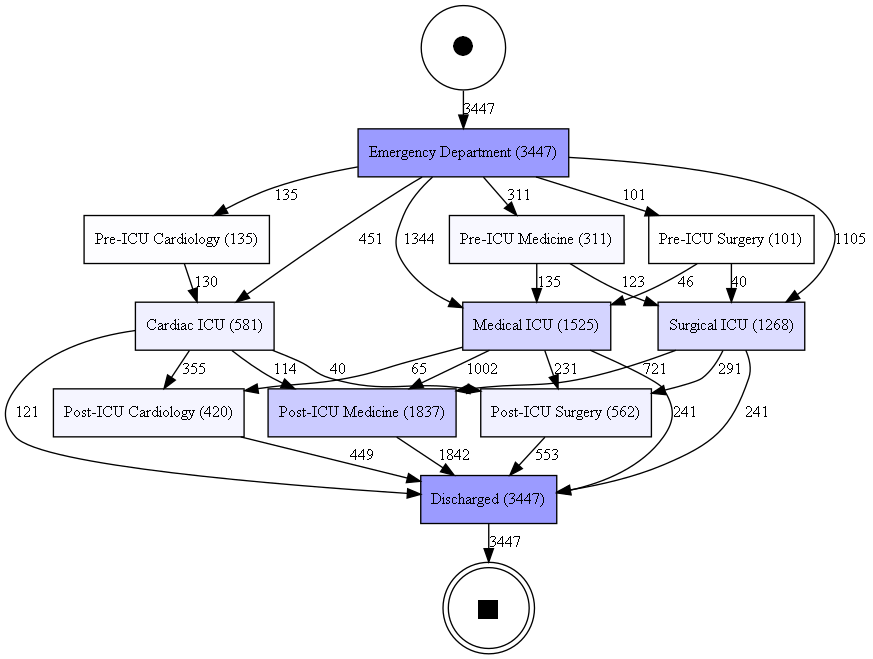

In [147]:
pm4py.view_dfg(dfg, sa, ea, att_config={})

In [148]:
rel_selection = widgets.SelectMultiple(
    options=rel_list,
    #value=['Oranges'],
    rows=10,
    #description='Relations',
    disabled=False,
    layout={'width': '95%'}
)

att_selection = widgets.SelectMultiple(
    options=att_list,
    #value=['Oranges'],
    rows=10,
    #description='Event Attributes',
    disabled=False,
    layout={'width': '95%'}
)

var_selection = widgets.SelectMultiple(
    options=var_list,
    #value=['Oranges'],
    rows=10,
    #description='Variants',
    disabled=False,
    layout={'width': '95%'}
)

def update_heatmap(info):
    heatmap.clear_output()
    plt.close('all')
    selected_rel = rel_selection.value
    selected_att = att_selection.value
    selected_var = var_selection.value
    selected_axis_rel = rel_drop.value
    selected_axis_att = att_drop.value
    selected_axis_var = var_drop.value
    x_axis = ""
    y_axis = ""
    z_axis = ""
    x_val = []
    y_val = []
    z_val = ""
    if "x-axis" in selected_axis_rel:
        x_axis = "Rel"
        x_val = selected_rel
    elif "x-axis" in selected_axis_att:
        x_axis = "E_At"
        x_val = selected_att
    elif "x-axis" in selected_axis_var:
        x_axis = "var"
        x_val = selected_var
    if "y-axis" in selected_axis_rel:
        y_axis = "Rel"
        y_val = selected_rel
    elif "y-axis" in selected_axis_att:
        y_axis = "E_At"
        y_val = selected_att
    elif "y-axis" in selected_axis_var:
        y_axis = "var"
        y_val = selected_var
    if "z-axis" in selected_axis_rel:
        z_axis = "Rel"
        z_val = selected_rel
    elif "z-axis" in selected_axis_att:
        z_axis = "E_At"
        z_val = selected_att
    elif "z-axis" in selected_axis_var:
        z_axis = "var"
        z_val = selected_var
    with heatmap:  
        df_con = con_All.loc[con_All["P"] <= p_threshold.value]
        hm = make_heatmap(df_con, x_axis, y_axis, x_val, y_val, "RBC", z_axis, z_val[0])
        plt.show()
        

heatmap_button = widgets.Button(
    description='Generate Heatmap',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
heatmap_button.on_click(update_heatmap)

p_threshold = widgets.BoundedFloatText(
    value=0.05,
    min=0,
    max=100.0,
    step=0.1,
    description='P-Threshold',
    disabled=False,
    layout = Layout(width = "40%")
)

heatmap_config = widgets.HBox([heatmap_button, p_threshold])

rel_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='y-axis', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)
att_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='x-axis', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)
var_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='z-axis (Choose only one!)', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)

rel_text = widgets.HTML(value= "Relations") 
att_text = widgets.Label(value="Attributes")
var_text = widgets.Label(value="Variants")
rel_h = widgets.HBox([rel_text, rel_drop])
att_h = widgets.HBox([att_text, att_drop])
var_h = widgets.HBox([var_text, var_drop])
rel_box = widgets.VBox([rel_h, rel_selection], layout=Layout(width='33%'))
att_box = widgets.VBox([att_h, att_selection, heatmap_config], layout=Layout(width='33%'))
var_box = widgets.VBox([var_h, var_selection], layout=Layout(width='33%'))

heatmap = widgets.Output(layout=Layout(width='100%'))

#### Single Cell Analysis ####

rel_dd = widgets.Dropdown(
    options=list(df_con.groupby(["Rel"]).count().sort_values("E_At", ascending=False).reset_index()["Rel"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)
att_dd = widgets.Dropdown(
    options=list(df_con.groupby(["E_At"]).count().sort_values("Rel", ascending=False).reset_index()["E_At"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)
var_dd = widgets.Dropdown(
    options=list(df_con.groupby(["var"]).count().sort_values("Rel", ascending=False).reset_index()["var"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)

def update_config(info):
    process_model.clear_output()
    selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
    selected_row = selected_row[["Rel", "M1", "M2", "ST1", "ST2", "RBC", "Directly", "#Patients"]]
    ele = {}
    ele["M1"] = selected_row["M1"].iloc[0].round(2)
    ele["M2"] = selected_row["M2"].iloc[0].round(2)
    ele["E_At"] = att_dd.value
    ele["RBC"] = selected_row["RBC"].iloc[0].round(2)
    ele["Directly"] = selected_row["Directly"].iloc[0]
    ele["N"] = selected_row["#Patients"].iloc[0]
    config[selected_row["Rel"].iloc[0]] = ele
    #gviz = dfg_visualization.apply(dfg, att_config=config, log=log, variant=dfg_visualization.Variants.FREQUENCY)
    gviz = pm4py.view_dfg(dfg, sa, ea, att_config=config)
    with process_model:
        display(dfg_visualization.view(gviz))

config_button = widgets.Button(
    description='Display chosen cell',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
config_button.on_click(update_config)

def update_config_All(info):
    #config = {}
    process_model.clear_output()
    selected_att = att_dd.value
    att_df = df_con.loc[(df_con["E_At"] == att_dd.value) & (df_con["var"] == var_dd.value)]
    #selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
    #selected_row = selected_row[["Rel", "M1", "M2", "ST1", "ST2", "RBC"]]
    if(len(att_df) > 0):
        for index, row in att_df.iterrows():
            ele = {}
            ele["M1"] = round(row["M1"], 2)
            ele["M2"] = round(row["M2"], 2)
            ele["E_At"] = att_dd.value
            ele["RBC"] = round(row["RBC"], 2)
            ele["Directly"] = row["Directly"]
            ele["N"] = row["#Patients"]
            config[row["Rel"]] = ele
        gviz = dfg_visualization.apply(dfg, att_config=config, log=log, variant=dfg_visualization.Variants.FREQUENCY)
        with process_model:
            display(dfg_visualization.view(gviz))

config_button_All = widgets.Button(
    description='Display all significant attribute changes',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
config_button_All.on_click(update_config_All)

config_buttons = widgets.HBox([config_button, config_button_All], layout=Layout(width='100%'))

Rel_DS = widgets.Output()

Rel_DS_box = widgets.VBox([Rel_DS, config_buttons], layout=Layout(width='50%', align_items='center'))

single_cell = widgets.VBox([rel_dd, att_dd, var_dd],layout=Layout(width='25%'))

cat_select = widgets.Dropdown(
    options=list(cat_All["E_At"].unique()),
    value=None,
    #description='',
    disabled=False,
    layout={'width': '95%'}
)
cat_text = widgets.Label(value="Link to categorical event attribute:")

cat_selection = widgets.VBox([cat_text, cat_select], layout=Layout(width='25%'))

single_DS = widgets.HBox([single_cell, Rel_DS_box, cat_selection], layout=Layout(width='100%'))

input_widgets = widgets.HBox(
[rel_box, att_box, var_box], layout=Layout(width='100%'))

cat_graph = widgets.Output(layout=Layout(align_items='center'))

output = widgets.VBox([input_widgets, heatmap, single_DS, cat_graph])

config = {}

process_model = widgets.Output()

var_num = []

def make_heatmap(df, x, y, x_val, y_val, val, z, filter_val, cat=False):
    var_num = []
    df = df.loc[df[z] == filter_val]
    if("Select All" not in x_val):
        df = df.loc[df[x].isin(x_val)]
    else:
        x_val = list(df_con.groupby([x]).count().sort_values("Rel", ascending=False).reset_index()[x])
    if("Select All" not in y_val):
        df = df.loc[df[y].isin(y_val)]
    else:
        y_val = list(df_con.groupby([y]).count().sort_values("Rel", ascending=False).reset_index()[y])
    if(x == "var"):
        for ele in x_val:
            var_num.append(ele)
            df.loc[df["var"] == ele, "var"] = var_num.index(ele)
    if(y == "var"):
        for ele in y_val:
            var_num.append(ele)
            df.loc[df["var"] == ele, "var"] = var_num.index(ele)
    df = df[[x, y, val]]
    df = df.pivot(index=y, columns=x, values=val)
    f, ax = plt.subplots(figsize=(12.5, 6))
    ax.tick_params(axis='y', which='major', labelsize=5)
    plt.yticks(wrap=True)
    if(cat == False):
        sns.heatmap(df, cmap="coolwarm", annot=True, vmin=-1, vmax=1)
    else:
        sns.heatmap(df, cmap="coolwarm", annot=True, vmin=0, vmax=200)
    x_labels = [item.get_text() for item in ax.get_xticklabels()]
    y_labels = [item.get_text() for item in ax.get_yticklabels()]
    t = f.suptitle('Event Attribute Change Matrix', fontsize=14)
    text=ax.text(0,0, "", va="bottom", ha="left")
    def onclick(event):
        Rel_DS.clear_output()
        #cat_graph.clear_output()
        x_cord = int(event.xdata)
        y_cord = int(event.ydata)
        x_lab = x_labels[x_cord]
        y_lab = y_labels[y_cord]
        if(x == "Rel"):
            rel_dd.value = x_lab
        elif(x == "E_At"):
            att_dd.value = x_lab
        elif(x == "var"):
            var_dd.value = var_num[int(x_lab)]
        if(y == "Rel"):
            rel_dd.value = y_lab
        elif(y == "E_At"):
            att_dd.value = y_lab
        elif(y == "var"):
            var_dd.value = var_num[int(y_lab)]
        if(z == "Rel"):
            rel_dd.value = filter_val
        elif(z == "E_At"):
            att_dd.value = filter_val
        elif(z == "var"):
            var_dd.value = filter_val
        #cat_select.value = "Abnormal" + " " + att_dd.value
        selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
        selected_row = selected_row[["P", "M1", "M2", "#Patients", "RBC"]]
        selected_row["M1"] = selected_row["M1"].round(2)
        selected_row["M2"] = selected_row["M2"].round(2)
        selected_row["RBC"] = selected_row["RBC"].round(2)
        selected_row["Type"] = "Continuous"
        selected_row = selected_row.rename({"M1":"Mean_1", "M2":"Mean_2", "RBC":"Test Statistic"}, axis=1)
        #selected_row_cat = cat_All.loc[(cat_All["Rel"] == rel_dd.value) & (cat_All["E_At"] == cat_select.value) & (cat_All["var"] == var_dd.value)]
        #selected_row_cat = selected_row_cat[["P", "Chi2", "#Patients"]]
        #selected_row_cat["Type"] = "Categorical"
        #selected_row_cat = selected_row_cat.rename({"Chi2":"Test Statistic"}, axis=1)
        #to_display = pd.concat([selected_row, selected_row_cat])
        to_display = selected_row
        to_display = to_display.reset_index().drop("index", axis=1)
        cols = to_display.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        to_display = to_display[cols]
        with Rel_DS:
            display(to_display)  
        selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
        directly = selected_row["Directly"].iloc[0]
        act_1 = selected_row["Act_1"].iloc[0]
        act_2 = selected_row["Act_2"].iloc[0]

        if(directly == 1.0):
            cons_df = consecutive_hadms(com_pm, act_1, act_2)
        else:
            cons_df = eventually_follow_hadms(com_pm, act_1, act_2)
        #dot, graph_vc, graph_cat  = create_graph(cons_df, act_1, act_2, att_dd.value, cat_select.value, var_dd.value)
        
        #with cat_graph:
        #    display(dot)
        
        
                
            
            
        
        
    cid = f.canvas.mpl_connect("button_press_event", onclick)
    return t, df
    

#create dataset for graph visualization
def create_graph(cons_df, dep1, dep2, att, cat_att, var):
    if(var != "ALL"):
        cons_df = cons_df.loc[cons_df["variant"] == var]
    graph_stats = cons_df[["hadm_id", "department", att, cat_att]]
    to_remove = graph_stats.loc[graph_stats[cat_att].isna()]["hadm_id"]
    graph_stats = graph_stats.loc[~graph_stats["hadm_id"].isin(to_remove)]
    cohort_size = len(graph_stats)/2
    curr_hadm = ""
    first_val = ""
    second_val = ""
    abnormal_col = graph_stats.columns[3]
    val_count = graph_stats[abnormal_col].value_counts()
    graph_cat = pd.DataFrame(columns=["Source", "Target", "Frequency"])
    for col_source in val_count.index:
        for col_target in val_count.index:
            new_row = {"Source":col_source, "Target":col_target, "Frequency": 0}
            graph_cat = graph_cat.append(new_row, ignore_index=True)
    for index, row in graph_stats.iterrows():
        if(curr_hadm != row["hadm_id"]):
            curr_hadm = row["hadm_id"]
            first_val = row[abnormal_col]
        else:
            second_val = row[abnormal_col]
            if((pd.isna(first_val)) | (pd.isna(second_val))):
                print("NaN")
            else:
                freq = graph_cat.loc[(graph_cat["Source"] == first_val) & (graph_cat["Target"] == second_val)]["Frequency"].iloc[0]
                graph_cat.loc[(graph_cat["Source"] == first_val) & (graph_cat["Target"] == second_val), "Frequency"] = freq+1

    graph_vc = pd.DataFrame(columns=["Val", "Pre-Frequency", "Post-Frequency"])
    for cat in val_count.index:
        try:
            pre_f = graph_stats.loc[graph_stats["department"] == dep1][abnormal_col].value_counts()[cat]
        except:
            pre_f = 0
        try:
            post_f = graph_stats.loc[graph_stats["department"] == dep2][abnormal_col].value_counts()[cat]
        except: 
            post_f = 0
        new_row = {"Val": cat, "Pre-Frequency": pre_f, "Post-Frequency": post_f}
        graph_vc = graph_vc.append(new_row, ignore_index=True)   
    #create graph and nodes
    dot = graphviz.Digraph()
    for node_name in val_count.index:
        pre_freq = graph_vc.loc[graph_vc["Val"] == node_name]["Pre-Frequency"].iloc[0] / cohort_size
        post_freq = graph_vc.loc[graph_vc["Val"] == node_name]["Post-Frequency"].iloc[0] / cohort_size
        pre_freq = pre_freq * 100
        post_freq = post_freq * 100
        post_freq = round(post_freq, 2)
        pre_freq = round(pre_freq, 2)
        #rel_text.value=node_name
        dot.node(node_name, node_name + r'\n' + dep1 + ": " + str(pre_freq) + '%' + r'\n' + dep2 + ": " + str(post_freq) + '%')
       # rel_text.value="lel" 

    #add edges
    for index, row in graph_cat.iterrows():
        if(row["Frequency"] > 0):
            label = row["Frequency"] / cohort_size
            label = label * 100
            label = round(label, 2)
            dot.edge(row["Source"], row["Target"], label = str(label) + "%")
    return dot, graph_vc, graph_cat


def consecutive_hadms(df, act_1, act_2):
    df = df.loc[df[activity].isin([act_1, act_2])]
    l = [] 
    hadms = df[case_id].unique()
    rows_list = []
    for hadm_id in hadms:
        curr_act = ""
        index_1 = 0
        first_row = ""
        df_hadm = df.loc[df[case_id] == hadm_id]
        for index, row in df_hadm.iterrows():
        #first act
            if((row[activity] == act_1) & (curr_act == "")):
                curr_act = row[activity]
                index_1 = index
                first_row = row
                continue
            elif((curr_act != "") & (row[activity] == act_2)):
                if(index - index_1 == 1):
                    rows_list.append(first_row)
                    rows_list.append(row)
                    curr_act = ""
                else:
                    curr_act = ""
                    
    return pd.DataFrame(rows_list)

def eventually_follow_hadms(df, act_1, act_2):
    df = df.loc[df[activity].isin([act_1, act_2])]
    l = [] 
    hadms = df[case_id].unique()
    rows_list = []
    for hadm_id in hadms:
        curr_act = ""
        first_row = ""
        df_hadm = df.loc[df[case_id] == hadm_id]
        for index, row in df_hadm.iterrows():
        #first act
            if((row[activity] == act_1) & (curr_act == "")):
                curr_act = row[activity]
                first_row = row
            elif((curr_act != "") & (row[activity] == act_2)):
                rows_list.append(first_row)
                rows_list.append(row)
                curr_act = ""
                
    return pd.DataFrame(rows_list)

In [149]:
config = {}

In [150]:
output